In [567]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [569]:
X_train = pd.read_csv('/content/drive/MyDrive/IVP_code/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/IVP_code/train_split.csv')
X_val = pd.read_csv('/content/drive/MyDrive/IVP_code/X_val.csv')
y_val = pd.read_csv('/content/drive/MyDrive/IVP_code/dev_split.csv')
X_test = pd.read_csv('/content/drive/MyDrive/IVP_code/X_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/IVP_code/test_split.csv')

y_train = y_train.drop(['Participant_ID','Gender','PHQ_Binary','PCL-C (PTSD)','PTSD Severity'],axis=1)
y_val = y_val.drop(['Participant_ID','Gender','PHQ_Binary','PCL-C (PTSD)','PTSD Severity'],axis=1)
y_test = y_test.drop(['Participant_ID','Gender','PHQ_Binary','PCL-C (PTSD)','PTSD Severity'],axis=1)

y_train.rename(columns={'PHQ_Score': 'Label'}, inplace=True)
y_val.rename(columns={'PHQ_Score': 'Label'}, inplace=True)
y_test.rename(columns={'PHQ_Score': 'Label'}, inplace=True)

In [570]:
column_to_modify = 'Label'
mask = y_train[column_to_modify] >= 10

y_train.loc[mask, column_to_modify] = 'stressed'
y_train.loc[~mask, column_to_modify] = 'distressed'

mask = y_val[column_to_modify] >= 10

y_val.loc[mask, column_to_modify] = 'stressed'
y_val.loc[~mask, column_to_modify] = 'distressed'

mask = y_test[column_to_modify] >= 10

y_test.loc[mask, column_to_modify] = 'stressed'
y_test.loc[~mask, column_to_modify] = 'distressed'

In [571]:
print(X_train)
# print(X_val)
print(y_train)
# print(y_val)

     Unnamed: 0      feat_0      feat_1     feat_2     feat_3     feat_4  \
0             0 -513.137198   83.663060  16.057766  24.280719   6.658524   
1             1 -471.437115   99.295008  -0.220501  18.568941  -5.084216   
2             2 -501.069253   92.922723   6.716990  20.736578  -0.910710   
3             3 -292.612770  135.936077  11.624582   3.729970   1.061355   
4             4 -273.155129  126.477685  -1.781663  12.334723 -10.016532   
..          ...         ...         ...        ...        ...        ...   
148         148 -578.201667   34.142229  12.953413  10.100522   5.090166   
149         149 -576.220968   69.613045  13.453139  10.514534   0.034174   
150         150 -646.559482   74.518509  24.308467  12.731603   7.648812   
151         151 -607.272128   70.614298  13.794390   5.820688   1.712109   
152         152 -595.401749   40.088937  16.247252  11.921119   6.195199   

       feat_5    feat_6    feat_7    feat_8  ...   feat_182   feat_183  \
0    5.474677

In [572]:
xTrainDNN = X_train.values
xvalDNN = X_val.values
xTestDNN = X_test.values
xTrainDNN.shape

(153, 193)

In [573]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train['Labels'] = label_encoder.fit_transform(y_train['Label'])
y_val['Labels'] = label_encoder.fit_transform(y_val['Label'])
y_test['Labels'] = label_encoder.fit_transform(y_test['Label'])
y_train

,Label,Labels
0,distressed,0
1,distressed,0
2,distressed,0
3,distressed,0
4,distressed,0
...,...,...
148,distressed,0
149,distressed,0
150,stressed,1
151,distressed,0


In [574]:
yTrainDNN = y_train['Labels']
yvalDNN = y_val['Labels']
yTestDNN = y_test['Labels']
yTrainDNN

0      0
1      0
2      0
3      0
4      0
      ..
148    0
149    0
150    1
151    0
152    0
Name: Labels, Length: 153, dtype: int64

In [575]:
yTrainDNN = np.array(yTrainDNN)
yvalDNN = np.array(yvalDNN)
yTestDNN = np.array(yTestDNN)
yTrainDNN

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [576]:
observedEmotions = ['Distressed','Stressed']

In [577]:
# Model configuration

batch_size = 16
no_epochs = 50
n_features = 193
n_testsize = X_val.shape[0]
n_classes = 2
validation_split = 0.15
verbosity = 1

In [578]:
modelDNN = Sequential([
    Dense(64,activation = 'relu',input_shape=(n_features,)),
#     Dropout(0.2),
    Dense(32,activation='relu'),
#     Dropout(0.2),
    Dense(1,activation = 'sigmoid')
])

In [579]:
modelDNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

modelDNN.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 64)                12416     
                                                                 
 dense_99 (Dense)            (None, 32)                2080      
                                                                 
 dense_100 (Dense)           (None, 1)                 33        
                                                                 
Total params: 14529 (56.75 KB)
Trainable params: 14529 (56.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [580]:
# Train the model
from tensorflow.keras.optimizers.legacy import Adam
# np.random.seed(42)
# tf.random.set_seed(42)
historyDNN = modelDNN.fit(xTrainDNN, yTrainDNN, batch_size=batch_size, epochs=no_epochs, verbose=verbosity)#possible accuracy improve



Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 4.5570 - accuracy: 0.6732
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 1.4343 - accuracy: 0.6013
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.8840 - accuracy: 0.6405
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.6536
Epoch 5/50
10/10 [==============================] - 0s 6ms/step - loss: 0.6245 - accuracy: 0.6732
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 0.5795 - accuracy: 0.6797
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.5645 - accuracy: 0.7190
Epoch 8/50
10/10 [==============================] - 0s 8ms/step - loss: 0.5680 - accuracy: 0.7386
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6078 - accuracy: 0.6928
Epoch 10/50
10/10 [==============================] - 0s 7ms/step - loss: 0.5890 - accuracy: 0.6928
Epoch 11/50
10/10 [

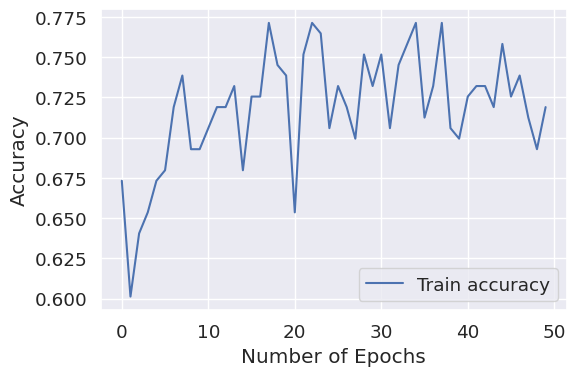

In [581]:
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.autolayout"] = True

plt_epochs = list(range(50))
acc = historyDNN.history['accuracy']
#val_acc = historyDNN.history['val_accuracy']

plt.plot(plt_epochs, acc, label='Train accuracy')
#plt.plot(plt_epochs, val_acc, label='Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

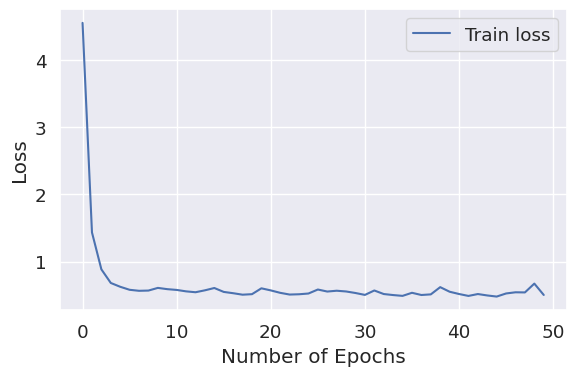

In [582]:
loss = historyDNN.history['loss']
#val_loss = historyDNN.history['val_loss']

plt.plot(plt_epochs, loss, label='Train loss')
#plt.plot(plt_epochs, val_loss, label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [583]:
yPredDNN = modelDNN.predict(xTestDNN)
yPredDNN = (yPredDNN >= 0.5).astype(int)
yPredDNN.shape

3/3 [==============================] - 0s 4ms/step


(88, 1)

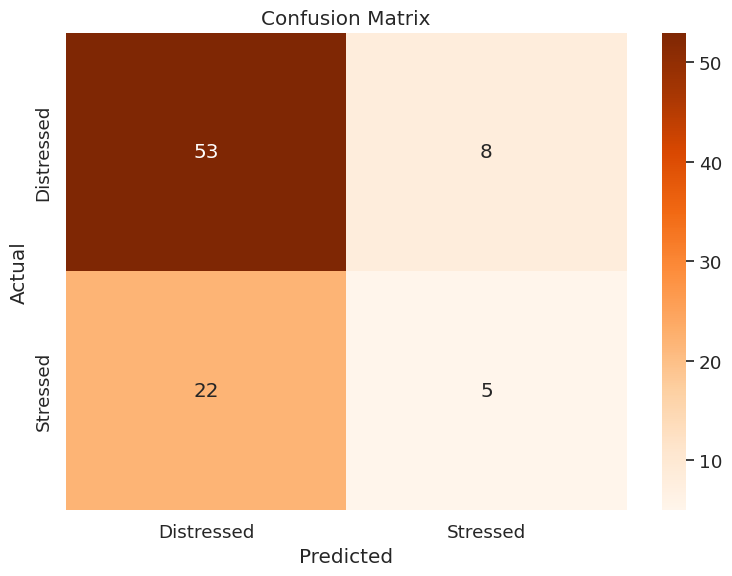

In [584]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(yTestDNN, yPredDNN)
conf_matrix
class_labels = ['Distressed', 'Stressed']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)

# Customize labels and appearance
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### CNN

In [585]:
xTrainCNN = [x for x in xTrainDNN]
xTrainCNN = np.array(xTrainCNN)
xTrainCNN.shape

(153, 193)

In [586]:
xTrainCNN = np.expand_dims(xTrainCNN, -1)
xTrainCNN.shape

(153, 193, 1)

In [587]:
xTestCNN = [x for x in xTestDNN]
xTestCNN = np.array(xTestCNN)
xTestCNN = np.expand_dims(xTestCNN, -1)
xTestCNN.shape

xvalCNN = [x for x in xvalDNN]
xvalCNN = np.array(xvalCNN)
xvalCNN = np.expand_dims(xvalCNN, -1)
xvalCNN.shape

(52, 193, 1)

In [588]:
# Create the model

modelCNN = Sequential([
    Conv1D(128, 8, activation='relu', input_shape=(n_features, 1)),
    MaxPooling1D(pool_size=(2)),
    # Dropout(0.2),
    Conv1D(64, 8, activation='relu'),
    MaxPooling1D(pool_size=(2)),
    # Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid'),
])

In [589]:
# Compile the model

modelCNN.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

modelCNN.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 186, 128)          1152      
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 93, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_23 (Conv1D)          (None, 86, 64)            65600     
                                                                 
 max_pooling1d_23 (MaxPooli  (None, 43, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 2752)              0         
                                                                 
 dense_101 (Dense)           (None, 1)               

In [590]:
# Train the model

historyCNN = modelCNN.fit(xTrainCNN, yTrainDNN, batch_size=batch_size, epochs=no_epochs, verbose=verbosity)

Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 1.6248 - accuracy: 0.4510
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.9164 - accuracy: 0.6013
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6993
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6308 - accuracy: 0.6340
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6117 - accuracy: 0.6993
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 0.6017 - accuracy: 0.6993
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6000 - accuracy: 0.6993
Epoch 8/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6201 - accuracy: 0.7059
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6394 - accuracy: 0.6732
Epoch 10/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6221 - accuracy: 0.6667
Epoch 11/50
10/10 [

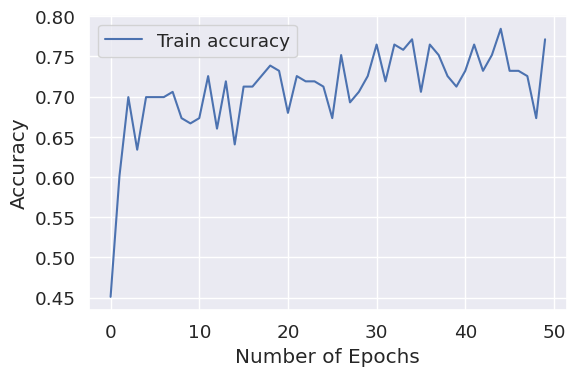

In [591]:
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.autolayout"] = True

plt_epochs = list(range(50))
acc = historyCNN.history['accuracy']
#val_acc = historyCNN.history['val_accuracy']

plt.plot(plt_epochs, acc, label='Train accuracy')
# plt.plot(plt_epochs, val_acc, label='Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

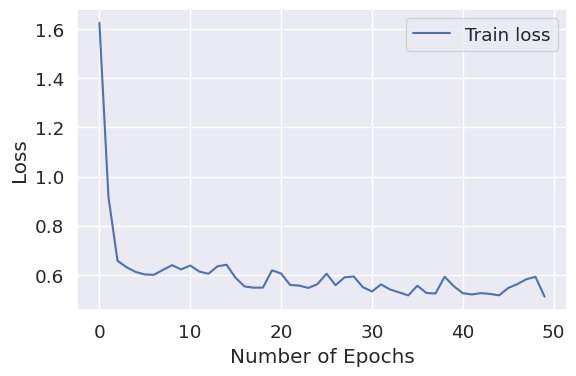

In [592]:
loss = historyCNN.history['loss']
#val_loss = historyCNN.history['val_loss']

plt.plot(plt_epochs, loss, label='Train loss')
# plt.plot(plt_epochs, val_loss, label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [593]:
yPredCNN = modelCNN.predict(xTestCNN)
yPredCNN = (yPredCNN >= 0.5).astype(int)
yPredCNN.shape

3/3 [==============================] - 0s 4ms/step


(88, 1)

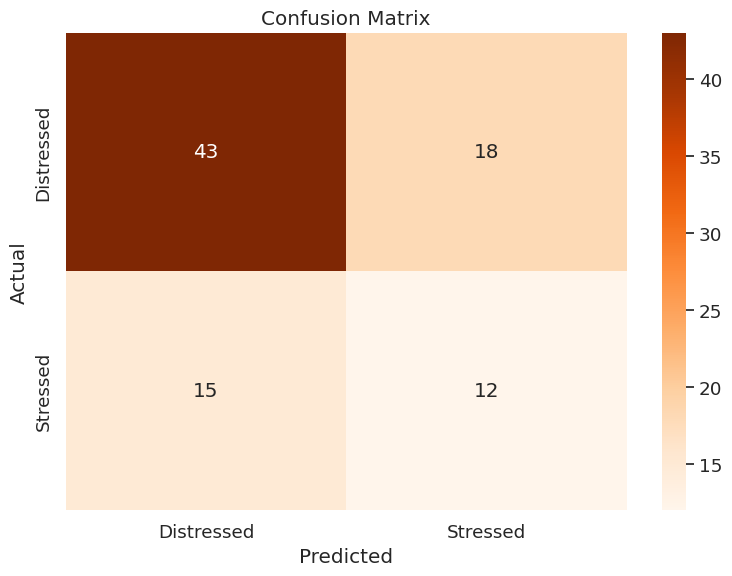

In [594]:
import seaborn as sns
conf_matrix = confusion_matrix(yTestDNN, yPredCNN)
conf_matrix
class_labels = ['Distressed', 'Stressed']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)

# Customize labels and appearance
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### LSTM

In [595]:
xTrainLSTM = [x for x in xTrainDNN]
for i in range(len(xTrainLSTM)):
    xTrainLSTM[i] = xTrainLSTM[i][:39]
xTrainLSTM = np.array(xTrainLSTM)
xTrainLSTM.shape

(153, 39)

In [596]:
xTrainLSTM = np.expand_dims(xTrainLSTM, -1)
xTrainLSTM.shape

(153, 39, 1)

In [597]:
xTestLSTM = [x for x in xTestDNN]
for i in range(len(xTestLSTM)):
    xTestLSTM[i] = xTestLSTM[i][:39]
xTestLSTM = np.array(xTestLSTM)
xTestLSTM = np.expand_dims(xTestLSTM, -1)
xTestLSTM.shape

(88, 39, 1)

In [598]:
# Create the model

modelLSTM = Sequential([
    LSTM(128, return_sequences=False, input_shape=(39, 1)),
    #Dropout(0.2),
    Dense(64, activation='relu'),
    #Dropout(0.2),
    Dense(32, activation='relu'),
    #Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

In [599]:
modelLSTM.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

modelLSTM.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128)               66560     
                                                                 
 dense_102 (Dense)           (None, 64)                8256      
                                                                 
 dense_103 (Dense)           (None, 32)                2080      
                                                                 
 dense_104 (Dense)           (None, 1)                 33        
                                                                 
Total params: 76929 (300.50 KB)
Trainable params: 76929 (300.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [600]:
# Train the model

historyLSTM = modelLSTM.fit(xTrainLSTM, yTrainDNN, batch_size=16, epochs=no_epochs)

Epoch 1/50
10/10 [==============================] - 3s 10ms/step - loss: 0.6422 - accuracy: 0.6078
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 0.6154 - accuracy: 0.6993
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 0.6166 - accuracy: 0.6993
Epoch 4/50
10/10 [==============================] - 0s 13ms/step - loss: 0.6283 - accuracy: 0.6993
Epoch 5/50
10/10 [==============================] - 0s 11ms/step - loss: 0.6152 - accuracy: 0.6993
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 0.6115 - accuracy: 0.6993
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 0.6096 - accuracy: 0.6993
Epoch 8/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6099 - accuracy: 0.6993
Epoch 9/50
10/10 [==============================] - 0s 11ms/step - loss: 0.6088 - accuracy: 0.6993
Epoch 10/50
10/10 [==============================] - 0s 10ms/step - loss: 0.6068 - accuracy: 0.6993
Epoch 11/5

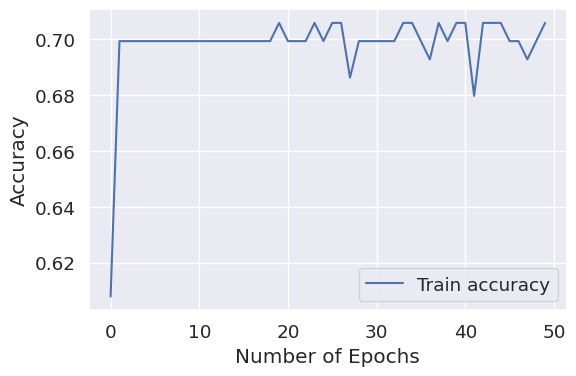

In [601]:
plt_epochs = list(range(50))
acc = historyLSTM.history['accuracy']
#val_acc = historyLSTM.history['val_accuracy']

plt.plot(plt_epochs, acc, label='Train accuracy')
# plt.plot(plt_epochs, val_acc, label='Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

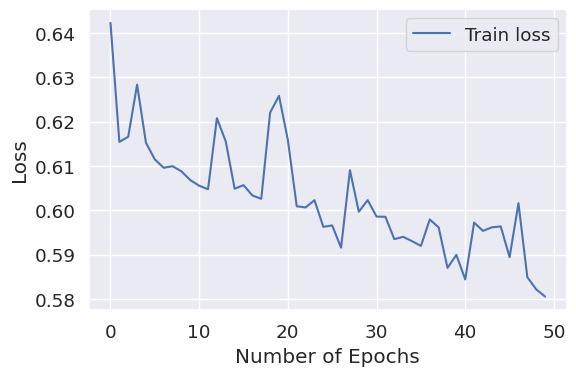

In [602]:
loss = historyLSTM.history['loss']
#val_loss = historyLSTM.history['val_loss']

plt.plot(plt_epochs, loss, label='Train loss')
# plt.plot(plt_epochs, val_loss, label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [603]:
yPredLSTM = modelLSTM.predict(xTestLSTM)
yPredLSTM = (yPredLSTM >= 0.5).astype(int)
yPredLSTM.shape

3/3 [==============================] - 0s 5ms/step


(88, 1)

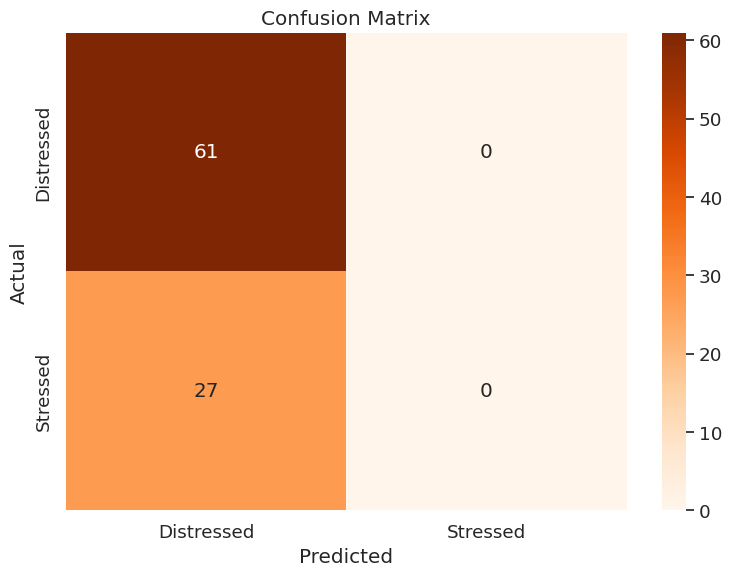

In [604]:
import seaborn as sns
conf_matrix = confusion_matrix(yTestDNN, yPredLSTM)
conf_matrix
class_labels = ['Distressed', 'Stressed']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)

# Customize labels and appearance
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [605]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(yTestDNN, yPredLSTM)
print(accuracy)

0.6931818181818182


In [606]:
from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(yTestDNN, yPredDNN)
print(accuracy3)


0.6590909090909091


In [607]:
from sklearn.metrics import accuracy_score
accuracy4 = accuracy_score(yTestDNN, yPredCNN)
print(accuracy4)

0.625
